# Allen Institute
## 02_profile
---
## Dataset
- `../data/m1_10x_viz/org_marker+_log.pkl`

## WorkFlow
- make configuration
- a) Heatmap
- b) tSNE
- c) Scatterplot
 
 
 **Notes)**
 
 if kernel dies during running codes, you can ommit completed sections indexed if alphabets

In [1]:
import os
import json
from typing import NamedTuple, Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from umap import UMAP

from tools.figure import cns_markers, cns_subtype_markers, custom_bwr, fig_kwarg, seurat
import tools.spongy_panda as spd

In [2]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_viz/orig_markers+_log.pkl"
    )
    marker: list = cns_markers
    label_df: pd.core.frame.DataFrame = pd.read_csv(
        "../data/m1_10x_meta/metadata.csv", index_col=0
    )
    save_dir: str = "../out/m1_10x/02_profile"
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [3]:
conf = Config(save_file=True)

In [4]:
os.makedirs(conf.save_dir, exist_ok=True)

---
## Data Visualization

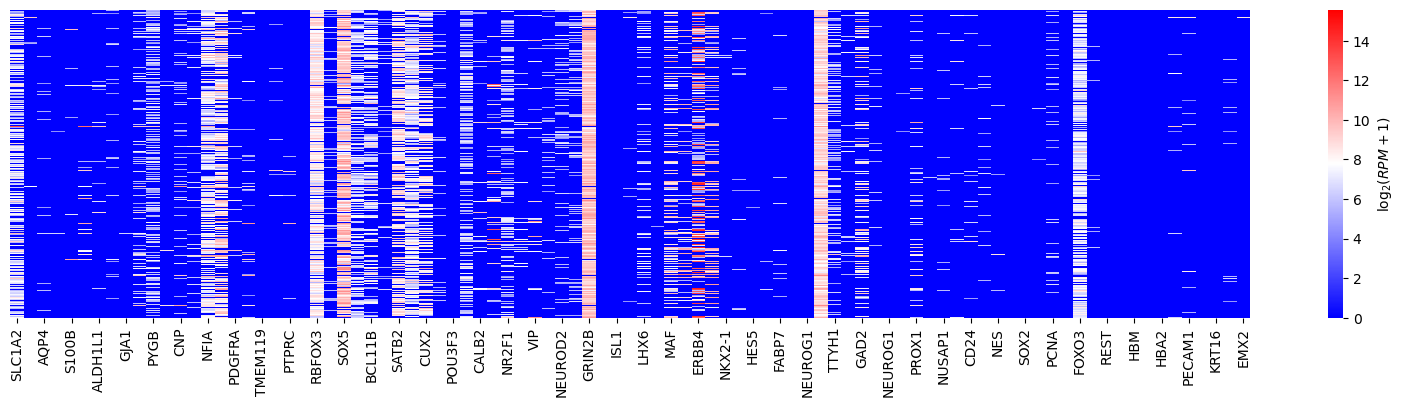

In [5]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.heatmap(
    conf.data[cns_subtype_markers], ax=ax, cmap="bwr",
    vmax=conf.data.max().max(),
    vmin=conf.data.min().min(),
    yticklabels=False
)
ax.set(ylabel="")
ax.collections[0].colorbar.set_label("$\log_2(RPM+1)$");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/heatmap.png", **conf.fig_kwarg)

---
## PCA

In [6]:
df_pca = pd.DataFrame(
    PCA(random_state=0, n_components="mle").fit_transform(conf.data[cns_subtype_markers]),
    index = conf.data.index
)

---
## UMAP

In [7]:
ngb = 15
min_dist = 1


df_umap = pd.DataFrame(
    UMAP(n_neighbors=ngb, min_dist=min_dist, random_state=0).fit_transform(df_pca),
    index=conf.data.index,
    columns=[f"UMAP{i+1}" for i in np.arange(2)]
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
class_dict = {v:i for i, v in enumerate(conf.label_df.class_label.unique())}
class_color = [
    plt.cm.jet(class_dict[v] / len(class_dict)) for v in class_dict
]

subclass_dict = {v:i for i, v in enumerate(conf.label_df.subclass_label.unique())}
subclass_color = [
    plt.cm.rainbow(subclass_dict[v] / len(subclass_dict)) for v in subclass_dict
]

In [10]:
center = df_umap.assign(label=conf.label_df.subclass_label).groupby("label").median()

In [11]:
fmt_dict = {
    v: i for i, v in enumerate(
        conf.label_df.subclass_label.sort_values().unique()
    )
}

subclass_label = pd.Series(
    [f"{fmt_dict[v]}: {v}" for v in conf.label_df.subclass_label.sort_values()],
    index = conf.label_df.subclass_label.sort_values().index
)

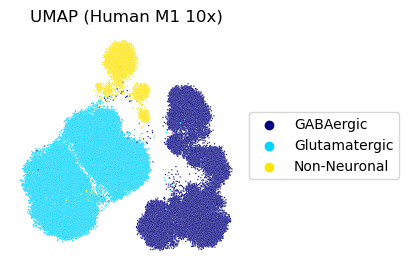

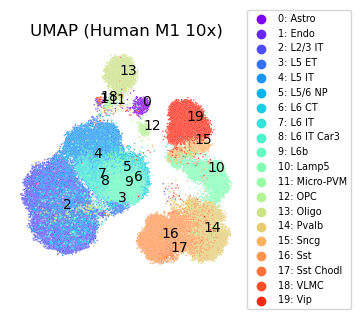

In [12]:
for hue, palette, name in zip(
    [conf.label_df.class_label, subclass_label],
    [class_color, subclass_color],
    ["class", "subclass"]
):

    fig, ax = plt.subplots(
        figsize=(3, 3)
    )

    sns.scatterplot(
        data=df_umap if name == "class" else df_umap.loc[subclass_label.index, :],
        x="UMAP1", y="UMAP2",
        hue=hue,
        palette=palette,
        **dict(s=1)
    )

    ax.set(
        title="UMAP (Human M1 10x)"
    )
    
    ax.axis("off")

    ax.legend(
        bbox_to_anchor=(1, .5), loc="center left",
        fontsize="x-small" if name == "subclass" else "medium"
    );
    
    if name == "subclass":
        for idx, clustername in enumerate(center.index):
            ax.annotate(idx, center.loc[clustername, :])

    if conf.save_file:
        plt.savefig(f"{conf.save_dir}/clustering_{name}.png", **conf.fig_kwarg)

---
## Export UMAPed data

In [13]:
df_umap.index.name = df_umap.index.name + f"\n(n_nbr:{ngb},min_dist:{min_dist})"
df_umap.to_pickle("../data/m1_10x_viz/umap.pkl")

---
## Profile

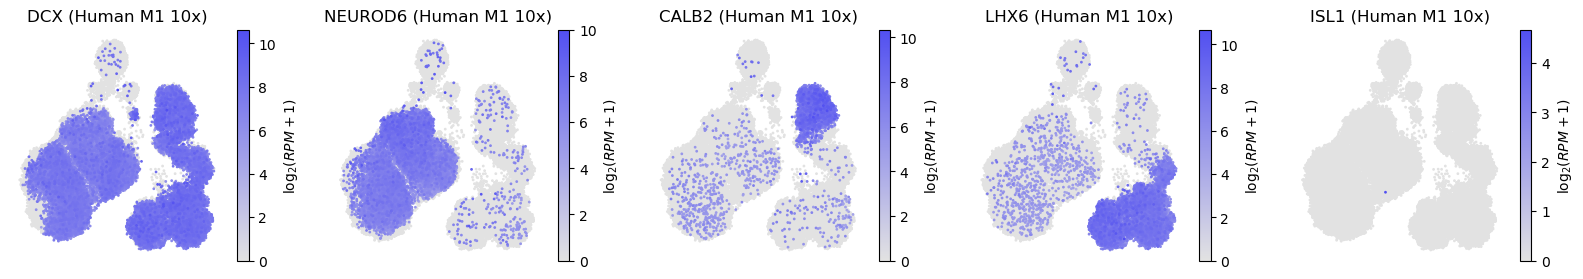

In [31]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 3))

for i, v in enumerate(["DCX", "NEUROD6", "CALB2", "LHX6", "ISL1"]):
    
    c = conf.data.loc[:, v].sort_values()
    
    df_umap.loc[c.index, :].plot.scatter(0, 1, c=c, cmap=seurat, ax=ax[i], s=1)

    ax[i].set(title=f"{v} (Human M1 10x)")
    
    ax[i].collections[0].colorbar.set_label("$\log_2(RPM+1)$")
    
    ax[i].axis("off")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/neuronal_markers.png", **conf.fig_kwarg)

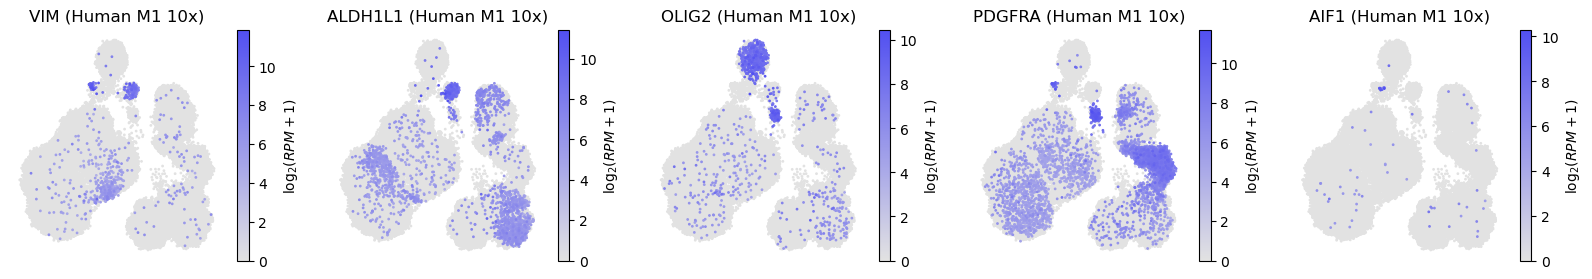

In [23]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 3))

for i, v in enumerate(["VIM", "ALDH1L1", "OLIG2", "PDGFRA", "AIF1"]):
    
    c = conf.data.loc[:, v].sort_values()
    
    df_umap.loc[c.index, :].plot.scatter(0, 1, c=c, cmap=seurat, ax=ax[i], s=1)
    
    ax[i].set(title=f"{v} (Human M1 10x)")
    
    ax[i].collections[0].colorbar.set_label("$\log_2(RPM+1)$")
    
    ax[i].axis("off")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/glial_markers.png", **conf.fig_kwarg)

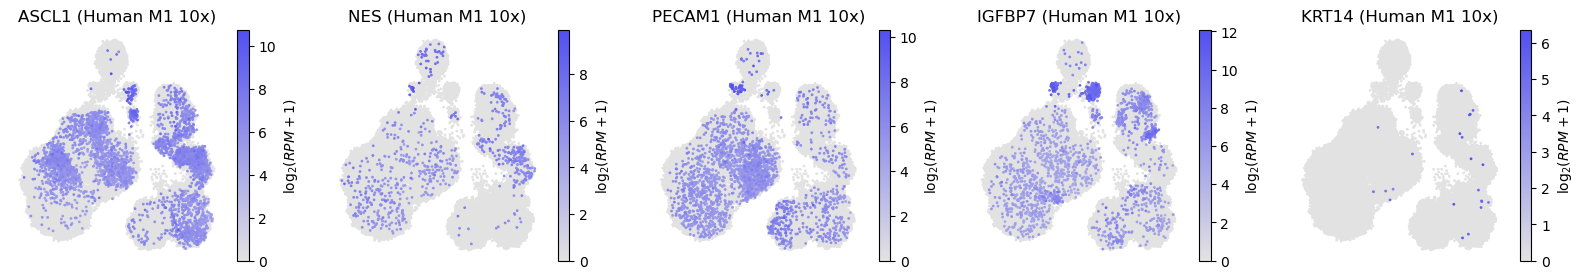

In [51]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 3))

for i, v in enumerate(["ASCL1", "NES", "PECAM1", "IGFBP7", "KRT14"]):
    
    c = conf.data.loc[:, v].sort_values()
    
    df_umap.loc[c.index, :].plot.scatter(0, 1, c=c, cmap=seurat, ax=ax[i], s=1)

    ax[i].set(title=f"{v} (Human M1 10x)")
    
    ax[i].collections[0].colorbar.set_label("$\log_2(RPM+1)$")
    
    ax[i].axis("off")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/other_markers.png", **conf.fig_kwarg)